# Build Basic RAG App

This tutorial demonstrates a complete Retrieval-Augmented Generation (RAG) system using Ray ecosystem components for scalable AI workflows.

Since we have already built the data ingestion pipeline in notebook #2, we'll just show how to buid the user query pipeline for RAG.

It showcases embedding generation, vector search, context-aware prompting, and streaming response delivery—all in a single executable pipeline.

Here is the architecture diagram:

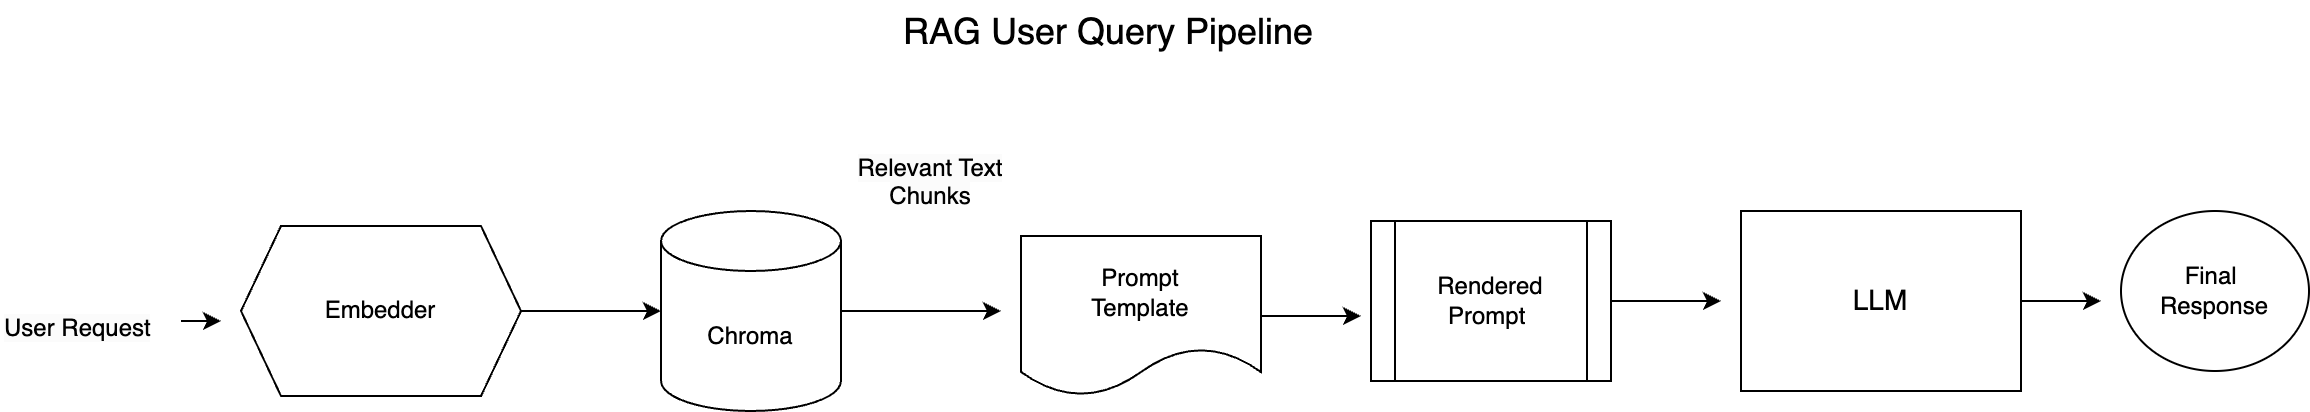

<div class="alert alert-block alert-warning">
  <b>Anyscale-Specific Configuration</b>
  
  <p>Note: This tutorial is optimized for the Anyscale platform. When running on open source Ray, additional configuration is required. For example, you’ll need to manually:</p>
  
  <ul>
    <li>
      <b>Configure your Ray Cluster:</b> Set up your multi-node environment (including head and worker nodes) and manage resource allocation (e.g., autoscaling, GPU/CPU assignments) without the Anyscale automation. See the Ray Cluster Setup documentation for details: <a href="https://docs.ray.io/en/latest/cluster/getting-started.html">https://docs.ray.io/en/latest/cluster/getting-started.html</a>.
    </li>
    <li>
      <b>Manage Dependencies:</b> Install and manage dependencies on each node since you won’t have Anyscale’s Docker-based dependency management. Refer to the Ray Installation Guide for instructions on installing and updating Ray in your environment: <a href="https://docs.ray.io/en/latest/ray-core/handling-dependencies.html">https://docs.ray.io/en/latest/ray-core/handling-dependencies.html</a>.
    </li>
    <li>
      <b>Set Up Storage:</b> Configure your own distributed or shared storage system (instead of relying on Anyscale’s integrated cluster storage). Check out the Ray Cluster Configuration guide for suggestions on setting up shared storage solutions: <a href="https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html">https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html</a>.
    </li>
  </ul>

</div>


## Prerequisites

Before you move on to the next steps, please make sure you have all the required prerequisites in place.


<div class="alert alert-block alert-warning"> <b> Pre-requisite #1: You must have finished the data ingestion in Chroma DB with CHROMA_PATH = "/mnt/cluster_storage/vector_store" and CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings". For setup details, please refer to Notebook #2.</b> 
<div>

<div class="alert alert-block alert-warning"> <b> Pre-requisite #2: You must have deployed the LLM service with `Qwen/Qwen2.5-32B-Instruct` model. For setup details, please refer to Notebook #3.</b> 
<div>

## Verify the LLM service

First, let's first verify the LLM service is available

In [ ]:
from rag_utils import LLMClient

# Initialize client
model_id='Qwen/Qwen2.5-32B-Instruct' ## model id need to be same as your deployment 
base_url = "https://llm-service-qwen-32b-jgz99.cld-kvedzwag2qa8i5bj.s.anyscaleuserdata.com/" ## replace with your own service base url
api_key = "a1ndpMKaXi76sTIfr_afmx8HynFA1fg-TGaZ2gUuDG0" ## replace with your own api key

client = LLMClient(base_url=base_url, api_key=api_key, model_id=model_id)

prompt = "what is anyscale jobs"
print("Model response:")
for token in client.get_response_streaming(prompt, temperature=0):
    print(token, end="")
print()  # For newline after the streamed response

Model response:
Anyscale Jobs likely refers to job opportunities or roles within the context of Anyscale, a company that specializes in scalable computing solutions. Anyscale is known for developing Ray, an open-source framework for building distributed applications. The company focuses on making it easier for developers and researchers to scale their applications and machine learning models across multiple machines.

If you're looking for information on specific job openings at Anyscale, you would typically find these on the company's official website under a "Careers" or "Jobs" section, or on popular job listing platforms. Positions might include roles in software engineering, machine learning, data science, and other technical fields, given the company's focus on scalable computing and distributed systems.


## Observation and Why we need RAG?

The response refers to job openings at Anyscale instead of explaining what "Anyscale jobs" are in the context of the platform: https://docs.anyscale.com/platform/jobs/

This demonstrates why RAG is needed—by integrating domain-specific context, we help the LLM produce more accurate answers.

## Build the embedder

Similar to previous tutorials, we use the `SentenceTransformer` library to convert text strings into numerical embeddings. The embedder automatically utilizes a CUDA-enabled GPU if available, making it efficient for both single and batch processing.

In [ ]:
from typing import Dict, List, Union
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

class Embedder:
    def __init__(self, model_name: str = "intfloat/multilingual-e5-large-instruct"):
        self.model_name = model_name
        self.model = SentenceTransformer(
            self.model_name,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
    
    def embed_single(self, text: str) -> np.ndarray:
        """Generate an embedding for a single text string."""
        return self.model.encode(text, convert_to_numpy=True)
    
    def embed_batch(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings for a batch (list) of text strings."""
        return self.model.encode(texts, convert_to_numpy=True)
    

## Query the Chroma DB

Similar to `ChromaWrite` class in previous tutotials, we define a `ChromaQuerier` class that acts as an interface to a Chroma vector store, enabling efficient retrieval of document chunks based on similarity to a provided query embedding. 

It processes raw results by reformatting and filtering them according to a defined score threshold, ensuring that only the most relevant information is returned. As part of a Retrieval-Augmented Generation (RAG) workflow, this setup helps integrate precise, contextually significant data into subsequent generation steps.

The `score_threshold` parameter sets the minimum acceptable similarity score for a result to be considered relevant. In this code, each result's score is calculated as 1 minus its distance, meaning that lower distances (indicating higher similarity) result in higher scores. By filtering out any results with scores below the score_threshold (defaulted to 0.8), the code ensures that only the most contextually relevant documents are returned.

We also implement two special method ,  `__getstate__` and `__setstate__`, which are  special hooks in Python's pickling protocol :
* `__getstate__`: Prepares the object for pickling by removing attributes that can’t be serialized, ensuring that only the essential state is saved.
* `__setstate__`: Rebuilds the object after unpickling by restoring its state and reinitializing the unpickleable components so that the object remains fully functional.

These two functions will prevent the error such as `TypeError: cannot pickle 'weakref.ReferenceType' object` when you use `map_batches` during batching processing with Ray data. 

In [ ]:
from pprint import pprint
import chromadb



class ChromaQuerier:
    """
    A class to query a Chroma database collection and return formatted search results.
    """
    def __init__(
        self, 
        chroma_path: str, 
        chroma_collection_name: str,
        score_threshold: float = 0.8  # Define a default threshold value if needed.
    ):
        """
        Initialize the ChromaQuerier with the specified Chroma DB settings and score threshold.
        """
        self.chroma_path = chroma_path
        self.chroma_collection_name = chroma_collection_name
        self.score_threshold = score_threshold

        # Initialize the persistent client and collection.
        self._init_chroma_client()

    def _init_chroma_client(self):
        """
        Initialize or reinitialize the Chroma client and collection.
        """
        self.chroma_client = chromadb.PersistentClient(path=self.chroma_path)
        self.collection = self.chroma_client.get_or_create_collection(name=self.chroma_collection_name)

    def __getstate__(self):
        """
        Customize pickling by excluding the unpickleable Chroma client and collection.
        """
        state = self.__dict__.copy()
        state.pop("chroma_client", None)
        state.pop("collection", None)
        return state

    def __setstate__(self, state):
        """
        Restore the state and reinitialize the Chroma client and collection.
        """
        self.__dict__.update(state)
        self._init_chroma_client()

    def _reformat(self, chroma_results: dict) -> list:
        """
        Reformat Chroma DB results into a flat list of dictionaries.
        """
        reformatted = []
        metadatas = chroma_results.get("metadatas", [])
        documents = chroma_results.get("documents", [])
        distances = chroma_results.get("distances", [])
        
        chunk_index = 1
        for meta_group, doc_group, distance_group in zip(metadatas, documents, distances):
            for meta, text, distance in zip(meta_group, doc_group, distance_group):
                entry = {
                    "chunk_index": chunk_index,
                    "chunk_id": meta.get("chunk_id"),
                    "doc_id": meta.get("doc_id"),
                    "page_number": meta.get("page_number"),
                    "source": meta.get("source"),
                    "text": text,
                    "distance": distance,
                    "score": 1 - distance
                }
                reformatted.append(entry)
                chunk_index += 1
        
        return reformatted

    def _reformat_batch(self, chroma_results: dict) -> list:
        """
        Reformat batch Chroma DB results into a list where each element corresponds
        to a list of dictionaries for each query embedding.
        """
        batch_results = []
        metadatas = chroma_results.get("metadatas", [])
        documents = chroma_results.get("documents", [])
        distances = chroma_results.get("distances", [])
        
        for meta_group, doc_group, distance_group in zip(metadatas, documents, distances):
            formatted_results = []
            chunk_index = 1  # Reset index for each query result.
            for meta, text, distance in zip(meta_group, doc_group, distance_group):
                entry = {
                    "chunk_index": chunk_index,
                    "chunk_id": meta.get("chunk_id"),
                    "doc_id": meta.get("doc_id"),
                    "page_number": meta.get("page_number"),
                    "source": meta.get("source"),
                    "text": text,
                    "distance": distance,
                    "score": 1 - distance
                }
                formatted_results.append(entry)
                chunk_index += 1
            batch_results.append(formatted_results)
        
        return batch_results

    def _filter_by_score(self, results: list) -> list:
        """
        Filter out results with a score lower than the specified threshold.
        """
        return [result for result in results if result["score"] >= self.score_threshold]

    def query(self, query_embedding, n_results: int = 3) -> list:
        """
        Query the Chroma collection for the top similar documents based on the provided embedding.
        The results are filtered based on the score threshold.

        Parameters:
            query_embedding (list or np.ndarray): The input embedding vector.
            n_results (int): Number of top similar results to return.

        Returns:
            list: A list of formatted and filtered search result dictionaries.
        """
        # Convert numpy array to list if necessary.
        if isinstance(query_embedding, np.ndarray):
            query_embedding = query_embedding.tolist()

        results = self.collection.query(
            query_embeddings=query_embedding,
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )
        
        formatted_results = self._reformat(results)
        filtered_results = self._filter_by_score(formatted_results)
        return filtered_results

    def query_batch(self, query_embeddings, n_results: int = 3) -> list:
        """
        Query the Chroma collection for the top similar documents for a batch of embeddings.
        Each query embedding in the input list returns its own set of results, filtered based on the score threshold.

        Parameters:
            query_embeddings (list): A list of embeddings (each as a list or np.ndarray).
            n_results (int): Number of top similar results to return for each query embedding.

        Returns:
            list: A list where each element is a list of formatted and filtered search result dictionaries 
                  for the corresponding query embedding.
        """
        # Process each embedding: if any is a numpy array, convert it to list.
        processed_embeddings = [
            emb.tolist() if isinstance(emb, np.ndarray) else emb
            for emb in query_embeddings
        ]
        
        # Query the collection with the batch of embeddings.
        results = self.collection.query(
            query_embeddings=processed_embeddings,
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )
        
        # Reformat the results into batches.
        batch_results = self._reformat_batch(results)
        
        # Filter each query's results based on the score threshold.
        filtered_batch = [self._filter_by_score(results) for results in batch_results]
        
        return filtered_batch



## Render the basic RAG prompt

Create a prompt that includes the retrieved context and the user’s question. This prompt guides the LLM to produce an answer that is informed by the context.

We are using a bisc prompt from langchain's rag bot: https://python.langchain.com/docs/tutorials/rag/

**Note:**
The quality of the prompt is not optimal; in our next tutorial on prompt engineering, we will demonstrate how to improve it.


In [ ]:

def render_basic_rag_prompt(user_request, context):
    prompt = f"""Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {user_request}

Helpful Answer:"""
    return prompt.strip()

## Connect the Components of RAG

Integrate the embedder, Chroma querier, and LLM service into a complete RAG pipeline.


In [ ]:

EMBEDDER_MODEL_NAME = "intfloat/multilingual-e5-large-instruct"
CHROMA_PATH = "/mnt/cluster_storage/vector_store"
CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings"


# Initialize the querier.
querier = ChromaQuerier(CHROMA_PATH, CHROMA_COLLECTION_NAME, score_threshold=0.8)
embedder = Embedder(EMBEDDER_MODEL_NAME)

# Perform the user request.
user_request = "what is a anyscale job"
embedding = embedder.embed_single(user_request)
formatted_results = querier.query(embedding, n_results=10)

# Print the formatted query results.
print("Query Results:")
pprint(formatted_results)

# Render the prompt. 
prompt = render_basic_rag_prompt(user_request, context=formatted_results)
print("Rendered Prompt:")
pprint(prompt) 

Query Results:
[{'chunk_id': '55b8db89-0aa6-460c-ae3a-284241f5865c',
  'chunk_index': 1,
  'distance': 0.10053980350494385,
  'doc_id': '7b170e3d-4081-4527-a737-1da022a364c4',
  'page_number': 1,
  'score': 0.8994601964950562,
  'source': 'anyscale-rag-application/100-docs/Jobs.txt',
  'text': '2/12/25, 9:48 AM Jobs | Anyscale Docs Jobs Run discrete workloads '
          'in production such as batch inference, bulk embeddings generation, '
          'or model fine-tuning. Anyscale Jobs allow you to submit '
          'applications developed on workspaces to a standalone Ray cluster '
          'for execution. Built for production and designed to fit into your '
          'CI/CD pipeline, jobs ensure scalable and reliable performance. How '
          'does it work? # When you’re ready to promote an app to production, '
          'submit a job from the workspace using anyscale job submit . '
          'Anyscale Jobs have the following features: Scalability: Rapid '
          'scaling to 


## Get the Final Response
Stream the response from the LLM using the generated prompt.


In [ ]:
for token in client.get_response_streaming(prompt, temperature=0.5):
    print(token, end="")


Anyscale Jobs are used to run discrete workloads in production, such as batch inference or model fine-tuning, on a standalone Ray cluster for scalable and reliable performance. Thanks for asking!

## Observations and Next Steps

As you can see, the LLM now understands that Anysacle jobs refers to the platform rather than job openings at Anysacale. This demonstrates the power of using RAG. However, the response from this basic RAG implementation is not optimal: it’s too short and lacks citations, leaving us unclear about the sources of the information. In future tutorials, we will assess these issues and propose several methods to address them through prompt engineering.